# PINN for the 1D Burger's equation

$$
\frac{\partial u}{\partial t}
+ u \frac{\partial u}{\partial x}
= \nu \frac{\partial^2 u}{\partial x^2},
\qquad
\nu = 0.
$$

with boundary conditions
$$
u(t,-1) = u(t,1) = 0,
$$

and initial condition
$$
u(0,x) = -\sin(\pi x).
$$

The space–time domain is
$$
\Omega = [0,1] \times [-1,1].
$$


In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.io as sio
import itertools
import time
import pandas as pd
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [ ]:
ALPHA = 0.1
X_MIN, X_MAX = -1.0, 1.0
T_MIN, T_MAX = 0.0, 4.0


data = sio.loadmat("burgers_hyp.mat")

x_ref = torch.tensor(data["x"], dtype=torch.float32).squeeze() 
t_ref = torch.tensor(data["t"], dtype=torch.float32).squeeze()     
u_ref = torch.tensor(data["usol"], dtype=torch.float32)
# enforce u_ref shape = (Nt, Nx)
if u_ref.shape == (len(x_ref), len(t_ref)):
    u_ref = u_ref.T
print("x_ref", data["x"].shape)
print("t_ref", data["t"].shape)
print("u_ref", data["usol"].shape)
@torch.no_grad()
def exact_solution(x, t):
    xq = x.detach().cpu().squeeze(1)   
    tq = t.detach().cpu().squeeze(1)  

    ix = torch.argmin(torch.abs(x_ref[:, None] - xq[None, :]), dim=0)  
    it = torch.argmin(torch.abs(t_ref[:, None] - tq[None, :]), dim=0)  

    y = u_ref[it, ix].unsqueeze(1) 
    return y.to(x.device)

def initial_condition_parabolic(x):
    return torch.sin(torch.pi * x)

def sample_interior(n):
    x = torch.rand(n, 1, device=device) * (X_MAX - X_MIN) + X_MIN
    t = torch.rand(n, 1, device=device) * (T_MAX - T_MIN) + T_MIN
    return x, t

def sample_initial(n):
    x = torch.rand(n, 1, device=device) * (X_MAX - X_MIN) + X_MIN
    t = torch.zeros_like(x) + T_MIN
    return x, t

def sample_boundary(n):
    t_left = torch.rand(n, 1, device=device) * (T_MAX - T_MIN) + T_MIN
    t_right = torch.rand(n, 1, device=device) * (T_MAX - T_MIN) + T_MIN
    x_left = torch.zeros_like(t_left) + X_MIN
    x_right = torch.zeros_like(t_right) + X_MAX
    return (x_left, t_left), (x_right, t_right)


x_ref (1, 1024)
t_ref (1, 101)
u_ref (101, 1024)


In [ ]:
# FVM baseline to generate experimental data
def solve_burgers_fvm(nx=256, nt_out=101, x_min=-1.0, x_max=1.0, t_max=1.0,
                      nu=0.01/np.pi, cfl=0.4, noise_std=0.0, seed=42):
    rng = np.random.default_rng(seed)
    x = np.linspace(x_min, x_max, nx)
    dx = x[1] - x[0]

    # Initial condition consistent with the classic Burgers setup
    u = -np.sin(np.pi * x)
    u[0] = 0.0
    u[-1] = 0.0

    t_out = np.linspace(0.0, t_max, nt_out)
    u_hist = np.zeros((nt_out, nx), dtype=np.float32)
    u_hist[0] = u

    t = 0.0
    k = 1
    while k < nt_out:
        umax = max(1e-6, np.max(np.abs(u)))
        dt_adv = cfl * dx / umax
        if nu > 0.0:
            dt_diff = 0.5 * dx * dx / nu
        else:
            dt_diff = np.inf
        dt = min(dt_adv, dt_diff, t_max - t)

        # Rusanov (local Lax-Friedrichs) flux for convection
        uL = u[:-1]
        uR = u[1:]
        fL = 0.5 * uL * uL
        fR = 0.5 * uR * uR
        alpha = np.maximum(np.abs(uL), np.abs(uR))
        fhat = 0.5 * (fL + fR) - 0.5 * alpha * (uR - uL)

        u_new = u.copy()
        if nu > 0.0:
            u_new[1:-1] = (
                u[1:-1]
                - (dt / dx) * (fhat[1:] - fhat[:-1])
                + (nu * dt / (dx * dx)) * (u[2:] - 2.0 * u[1:-1] + u[:-2])
            )
        else:
            u_new[1:-1] = (
                u[1:-1]
                - (dt / dx) * (fhat[1:] - fhat[:-1])
            )
        u_new[0] = 0.0
        u_new[-1] = 0.0

        u = u_new
        t += dt

        while k < nt_out and t >= t_out[k] - 1e-12:
            u_hist[k] = u
            k += 1

    if noise_std > 0.0:
        u_hist = u_hist + noise_std * rng.standard_normal(u_hist.shape)

    return x, t_out, u_hist

x_fvm, t_fvm, u_fvm = solve_burgers_fvm(nx=1024, nt_out=101, noise_std=0.0, nu = 0, t_max = 1.0)
print('FVM grids:', x_fvm.shape, t_fvm.shape, u_fvm.shape)

plt.figure(figsize=(7, 4))
plt.pcolormesh(t_fvm, x_fvm, u_fvm.T, shading='auto', cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('FVM solution u(x,t)')
plt.colorbar(label='u')
plt.tight_layout()
plt.show()


In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

def plot_burgers_mat(path="burgers_hyp.mat"):
    data = sio.loadmat(path)

    x = data["x"].squeeze()   
    t = data["t"].squeeze()     
    u = data["usol"]            

    if u.shape == (len(t), len(x)):
        u = u.T
    plt.figure(figsize=(7, 4))
    plt.pcolormesh(t, x, u, shading="auto", cmap="jet")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Burgers solution u(x,t)")
    plt.colorbar(label="u")
    plt.tight_layout()
    plt.show()



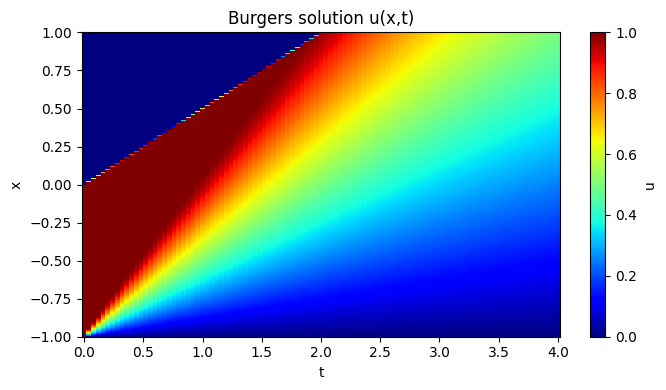

In [4]:
plot_burgers_mat("burgers_hyp.mat")


In [ ]:
class BurgersPINN(torch.nn.Module):
    def __init__(
        self,
        hidden_layers: int = 4,
        hidden_width: int = 64,
        hard_boundary: bool = False,
        hard_init: bool = False,
        activation='tanh',
    ):
        super().__init__()

        def make_activation(act):
            if isinstance(act, str):
                key = act.lower()
                if key == 'relu':
                    return torch.nn.ReLU()
                if key == 'gelu':
                    return torch.nn.GELU()
                if key == 'tanh':
                    return torch.nn.Tanh()
                raise ValueError(f"Unsupported activation: {act}")
            if isinstance(act, type) and issubclass(act, torch.nn.Module):
                return act()
            if isinstance(act, torch.nn.Module):
                return act.__class__()
            raise TypeError('string or torch.nn only')

        layers = []
        in_features = 2
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(in_features, hidden_width))
            layers.append(make_activation(activation))
            in_features = hidden_width
        layers.append(torch.nn.Linear(in_features, 1))
        self.model = torch.nn.Sequential(*layers)
        self.hard_boundary = hard_boundary
        self.hard_init = hard_init

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, t], dim=1)
        out = self.model(inputs)
        if self.hard_boundary:  # hard boundary on both the initial and boundary conditions, CHANGE ACCORDING TO PINN DETAILS
            xi = (x - X_MIN) / (X_MAX - X_MIN)
            out = (xi * (1.0 - xi) * out)
        if self.hard_init:
            out = -torch.sin(torch.pi * x) + t * out
        return out

def burgers_residual(model: BurgersPINN, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    ones = torch.ones_like(u)
    u_t = torch.autograd.grad(u, t, ones, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, ones, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, ones, create_graph=True)[0]
    v = 0.01 / torch.pi
    return u_t + u * u_x - v * u_xx


In [7]:
def train_pinn(layers, width, steps, lr, interior_samples, boundary_samples, initial_samples, hard_boundary, hard_init, activation):
    model = BurgersPINN(hidden_layers=layers, hidden_width=width, hard_boundary=hard_boundary, hard_init = hard_init, activation=activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []

    for step in range(1, steps + 1):
        optimizer.zero_grad(set_to_none=True)

        x_i, t_i = sample_interior(interior_samples)
        residual = burgers_residual(model, x_i, t_i)
        loss_residual = residual.pow(2).mean()

        loss_boundary = torch.tensor(0.0, device=device)
        
        loss_initial = torch.tensor(0.0, device=device)
        if not hard_boundary:
            (x_b0, t_b0), (x_b1, t_b1) = sample_boundary(boundary_samples)
            u_b0 = model(x_b0, t_b0)
            u_b1 = model(x_b1, t_b1)
            loss_boundary = u_b0.pow(2).mean() + u_b1.pow(2).mean()

        if not hard_init:
            
            x_init, t_init = sample_initial(initial_samples)
            u_init = model(x_init, t_init)
            target_init = exact_solution(x_init, t_init)
            loss_initial = (u_init - target_init).pow(2).mean()
        loss = loss_residual + loss_initial + loss_boundary
        loss.backward()
        optimizer.step()

        history.append({
            'step': step,
            'loss': float(loss.item()),
            'residual': float(loss_residual.item()),
            'initial': float(loss_initial.item()),
            'boundary': float(loss_boundary.item()),
        })

        if step % 500 == 0 or step == 1:
            tag = 'hard' if hard_boundary else 'soft'
            msg = f"[{tag}] step {step:4d} | total={loss.item():.3e} | residual={loss_residual.item():.3e} | init={loss_initial.item():.3e}"
            if not hard_boundary:
                msg += f" | bc={loss_boundary.item():.3e}"
            print(msg)

    return model


In [8]:
@torch.no_grad()
def evaluate_model(model: BurgersPINN, num_x: int = 100, num_t: int = 100):
    x = torch.linspace(X_MIN, X_MAX, num_x, device=device)
    t = torch.linspace(T_MIN, T_MAX, num_t, device=device)
    X, T = torch.meshgrid(x, t, indexing='ij')

    Xf = X.reshape(-1, 1)
    Tf = T.reshape(-1, 1)

    U = model(Xf, Tf).reshape(num_x, num_t)
    U_exact = exact_solution(Xf, Tf).reshape(num_x, num_t)

    error = (U - U_exact).abs()
    return X.cpu().numpy(), T.cpu().numpy(), U.cpu().numpy(), U_exact.cpu().numpy(), error.cpu().numpy()



In [9]:
def plot_heatmaps(X, T, prediction, truth, error, title_prefix, axes_row):
    im0 = axes_row[0].pcolormesh(T, X, prediction, shading='auto', cmap='jet')
    axes_row[0].set_title(f'{title_prefix} prediction')
    axes_row[0].set_xlabel('t')
    axes_row[0].set_ylabel('x')
    plt.colorbar(im0, ax=axes_row[0])

    im1 = axes_row[1].pcolormesh(T, X, truth, shading='auto', cmap='jet')
    axes_row[1].set_title('analytic solution')
    axes_row[1].set_xlabel('t')
    axes_row[1].set_ylabel('x')
    plt.colorbar(im1, ax=axes_row[1])

    im2 = axes_row[2].pcolormesh(T, X, error, shading='auto', cmap='magma')
    axes_row[2].set_title('absolute error')
    axes_row[2].set_xlabel('t')
    axes_row[2].set_ylabel('x')
    plt.colorbar(im2, ax=axes_row[2])



In [10]:
def grid_search_architectures(
    layers_list=(3, 4),
    width_list=(32, 64),
    activation_list=('relu', 'gelu', 'tanh'),
    lr=1e-3,
    steps=1500,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=True,
    hard_init=True,
    seed=42,
    eval_num_x=100,
    eval_num_t=100,
    max_runs=None,
    print_each=True,
    top_n=5,
    return_df=False,
):  # noqa: D401
    """Grid search over layer count, width, and activation."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    def train_once(cfg):
        model = BurgersPINN(
            hidden_layers=cfg['hidden_layers'],
            hidden_width=cfg['hidden_width'],
            activation=cfg['activation'],
            hard_boundary=cfg['hard_boundary'],
            hard_init=cfg['hard_init'],
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])

        for _ in range(cfg['steps']):
            optimizer.zero_grad(set_to_none=True)
            x_i, t_i = sample_interior(cfg['interior_samples'])
            residual = burgers_residual(model, x_i, t_i)
            loss_residual = residual.pow(2).mean()

            loss_boundary = torch.tensor(0.0, device=device)
            if not cfg['hard_boundary']:
                (x_b0, t_b0), (x_b1, t_b1) = sample_boundary(cfg['boundary_samples'])
                u_b0 = model(x_b0, t_b0)
                u_b1 = model(x_b1, t_b1)
                loss_boundary = u_b0.pow(2).mean() + u_b1.pow(2).mean()

            loss_initial = torch.tensor(0.0, device=device)
            if not cfg['hard_init']:
                x_init, t_init = sample_initial(cfg['initial_samples'])
                u_init = model(x_init, t_init)
                target_init = exact_solution(x_init, t_init)
                loss_initial = (u_init - target_init).pow(2).mean()

            loss = loss_residual + loss_initial + loss_boundary
            loss.backward()
            optimizer.step()

        return model, float(loss.item())

    configs = []
    for layers in layers_list:
        for width in width_list:
            for act in activation_list:
                configs.append({
                    'hidden_layers': layers,
                    'hidden_width': width,
                    'activation': act,
                    'lr': lr,
                    'steps': steps,
                    'interior_samples': interior_samples,
                    'boundary_samples': boundary_samples,
                    'initial_samples': initial_samples,
                    'hard_boundary': hard_boundary,
                    'hard_init': hard_init,
                })

    if max_runs is not None:
        configs = configs[:max_runs]

    results = []
    best = None

    for idx, cfg in enumerate(configs, start=1):
        model, loss = train_once(cfg)
        X, T, U, U_exact, err = evaluate_model(model, num_x=eval_num_x, num_t=eval_num_t)
        err_t = torch.tensor(err)
        mse = float((err_t ** 2).mean().item())

        row = {**cfg}
        row.update({'loss': loss, 'mse': mse})
        results.append(row)

        if best is None or mse < best['mse']:
            best = {
                'cfg': cfg,
                'mse': mse,
                'loss': loss,
                'model': model,
                'eval': (X, T, U, U_exact, err),
            }

        if print_each:
            print(
                f"[{idx}/{len(configs)}] layers={cfg['hidden_layers']} width={cfg['hidden_width']} "
                f"act={cfg['activation']} | loss={loss:.3e} | mse={mse:.3e}"
            )

    df = pd.DataFrame(results)
    if df.empty:
        print('No runs executed.')
        return (df, best) if return_df else best

    cols = [
        'hidden_layers', 'hidden_width', 'activation',
        'lr', 'steps', 'interior_samples', 'boundary_samples', 'initial_samples',
        'hard_boundary', 'hard_init', 'loss', 'mse'
    ]
    df_display = df[cols].copy().round(3)

    if top_n and top_n > 0:
        print('\nTop runs by MSE:')
        print(df_display.sort_values('mse').head(top_n).to_string(index=False))

    return (df, best) if return_df else best


In [11]:
def sweep_hyperparams(
    lr_list=(1e-3,),
    steps_list=(1500, 2500,),
    interior_list=(512, 256 ,128),
    boundary_list=(512, 256 ,128),
    initial_list=(512, 256 ,128),
    hidden_layers_list=(4,),
    hidden_width_list=(64,),
    hard_boundary_list=(True,),
    seed=42,
    eval_num_x=100,
    eval_num_t=100,
    max_runs=None,
):
    """Grid sweep over hyperparameters and print summary tables."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    def train_once(cfg):
        model = BurgersPINN(
            hidden_layers=cfg['hidden_layers'],
            hidden_width=cfg['hidden_width'],
            hard_boundary=cfg['hard_boundary'],
            hard_init=cfg['hard_init'],
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])

        for _ in range(cfg['steps']):
            optimizer.zero_grad(set_to_none=True)
            x_i, t_i = sample_interior(cfg['interior_samples'])
            residual = burgers_residual(model, x_i, t_i)
            loss_residual = residual.pow(2).mean()

            loss_boundary = torch.tensor(0.0, device=device)
            if not cfg['hard_boundary']:
                (x_b0, t_b0), (x_b1, t_b1) = sample_boundary(cfg['boundary_samples'])
                u_b0 = model(x_b0, t_b0)
                u_b1 = model(x_b1, t_b1)
                loss_boundary = u_b0.pow(2).mean() + u_b1.pow(2).mean()

            loss_initial = torch.tensor(0.0, device=device)
            if not cfg['hard_init']:
                x_init, t_init = sample_initial(cfg['initial_samples'])
                u_init = model(x_init, t_init)
                target_init = exact_solution(x_init, t_init)
                loss_initial = (u_init - target_init).pow(2).mean()

            loss = loss_residual + loss_initial + loss_boundary
            loss.backward()
            optimizer.step()

        return model, float(loss.item())

    configs = []
    for combo in itertools.product(
        lr_list, steps_list, interior_list, boundary_list, initial_list,
        hidden_layers_list, hidden_width_list, hard_boundary_list
    ):
        cfg = {
            'lr': combo[0],
            'steps': combo[1],
            'interior_samples': combo[2],
            'boundary_samples': combo[3],
            'initial_samples': combo[4],
            'hidden_layers': combo[5],
            'hidden_width': combo[6],
            'hard_boundary': combo[7],
            'hard_init': combo[7],
        }
        configs.append(cfg)

    if max_runs is not None:
        configs = configs[:max_runs]

    results = []
    best_soft = None
    best_hard = None

    for idx, cfg in enumerate(configs, start=1):
        start = time.time()
        model, loss = train_once(cfg)
        X, T, U, U_exact, err = evaluate_model(model, num_x=eval_num_x, num_t=eval_num_t)
        err_t = torch.tensor(err)
        mse = float((err_t ** 2).mean().item())
        elapsed = time.time() - start

        row = {**cfg}
        row.update({
            'loss': loss,
            'mse': mse,
            'seconds': elapsed,
        })
        results.append(row)

        best = best_hard if cfg['hard_boundary'] else best_soft
        if best is None or mse < best['mse']:
            snapshot = {
                'cfg': cfg,
                'mse': mse,
                'loss': loss,
                'model': model,
                'eval': (X, T, U, U_exact, err),
            }
            if cfg['hard_boundary']:
                best_hard = snapshot
            else:
                best_soft = snapshot

        print(f"[{idx}/{len(configs)}] lr={cfg['lr']}, steps={cfg['steps']}, hard={cfg['hard_boundary']} | loss={loss:.3e} | mse={mse:.3e}")

    df = pd.DataFrame(results)
    if df.empty:
        print('No runs executed.')
        return df

    cols = [
        'lr', 'steps', 'interior_samples', 'boundary_samples', 'initial_samples',
        'hidden_layers', 'hidden_width', 'hard_boundary', 'hard_init', 'loss', 'mse', 'seconds'
    ]
    df_display = df[cols].copy()
    df_display = df_display.round(2)

    print('\nTop runs by MSE:')
    print(df_display.sort_values('mse').head(10).to_string(index=False))

    print('\nMean metrics by hyperparameter:')
    for col in ['lr', 'steps', 'interior_samples', 'boundary_samples', 'initial_samples', 'hidden_layers', 'hidden_width', 'hard_boundary']:
        summary = df.groupby(col)[['loss', 'mse']].mean().round(2).sort_values('mse')
        print(f"\n[{col}]")
        print(summary.to_string())

    if best_soft is not None and best_hard is not None:
        (Xs, Ts, soft_pred, soft_true, soft_err) = best_soft['eval']
        (Xh, Th, hard_pred, hard_true, hard_err) = best_hard['eval']
        fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)
        plot_heatmaps(Xs, Ts, soft_pred, soft_true, soft_err, 'Soft PINN (best)', axes[0])
        plot_heatmaps(Xh, Th, hard_pred, hard_true, hard_err, 'Hard PINN (best)', axes[1])
        plt.show()

    return df


In [12]:
best_combo = train_pinn(4,128, 3500, 1e-3, 512, 128, 512, False, False, 'gelu')

c:\Users\dimit\Desktop\Master 2\T6\DL for NLP\nlp\Lib\site-packages\torch\autograd\graph.py:865: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[soft] step    1 | total=5.039e-01 | residual=7.898e-06 | init=5.038e-01 | bc=3.788e-05
[soft] step  500 | total=5.338e-02 | residual=2.240e-02 | init=2.651e-02 | bc=4.472e-03
[soft] step 1000 | total=2.891e-02 | residual=1.245e-02 | init=1.293e-02 | bc=3.526e-03
[soft] step 1500 | total=1.693e-02 | residual=6.793e-03 | init=7.331e-03 | bc=2.804e-03
[soft] step 2000 | total=1.684e-02 | residual=8.785e-03 | init=6.617e-03 | bc=1.434e-03
[soft] step 2500 | total=2.189e-02 | residual=9.821e-03 | init=5.602e-03 | bc=6.465e-03
[soft] step 3000 | total=1.267e-02 | residual=8.167e-03 | init=3.614e-03 | bc=8.928e-04
[soft] step 3500 | total=1.440e-02 | residual=9.350e-03 | init=4.720e-03 | bc=3.297e-04


In [ ]:
class SpectralConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, modes_x, modes_t):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_x = modes_x
        self.modes_t = modes_t
        scale = 1.0 / (in_channels * out_channels)
        self.weight = torch.nn.Parameter(
            scale * torch.randn(in_channels, out_channels, modes_x, modes_t, dtype=torch.cfloat)
        )

    def forward(self, x):
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(
            x.size(0),
            self.out_channels,
            x.size(-2),
            x_ft.size(-1),
            dtype=torch.cfloat,
            device=x.device,
        )
        out_ft[:, :, : self.modes_x, : self.modes_t] = torch.einsum(
            'bixy,ioxy->boxy',
            x_ft[:, :, : self.modes_x, : self.modes_t],
            self.weight,
        )
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(torch.nn.Module):
    def __init__(self, in_channels=2, out_channels=1, width=32, modes_x=16, modes_t=16, layers=4):
        super().__init__()
        self.width = width
        self.lift = torch.nn.Conv2d(in_channels, width, 1)
        self.spectral_layers = torch.nn.ModuleList()
        self.pointwise_layers = torch.nn.ModuleList()
        for _ in range(layers):
            self.spectral_layers.append(SpectralConv2d(width, width, modes_x, modes_t))
            self.pointwise_layers.append(torch.nn.Conv2d(width, width, 1))
        self.proj = torch.nn.Sequential(
            torch.nn.Conv2d(width, width, 1),
            torch.nn.GELU(),
            torch.nn.Conv2d(width, out_channels, 1),
        )

    def forward(self, x):
        x = self.lift(x)
        for spec, pw in zip(self.spectral_layers, self.pointwise_layers):
            x = torch.nn.functional.gelu(spec(x) + pw(x))
        x = self.proj(x)
        return x


def fno_prepare_burgers_grid(path='burgers_hyp.mat'):
    data = sio.loadmat(path)
    x = torch.tensor(data['x'], dtype=torch.float32).squeeze()
    t = torch.tensor(data['t'], dtype=torch.float32).squeeze()
    u = torch.tensor(data['usol'], dtype=torch.float32)
    if u.shape == (len(x), len(t)):
        u = u.T
    u = u.T
    X, T = torch.meshgrid(x, t, indexing='ij')
    inp = torch.stack([X, T], dim=0).unsqueeze(0) 
    out = u.unsqueeze(0).unsqueeze(0)  
    return inp, out, x, t


def fno_predict_points(model, x_pts, t_pts):
    x_flat = x_pts.squeeze(1)
    t_flat = t_pts.squeeze(1)
    xs = torch.unique(x_flat).sort().values
    ts = torch.unique(t_flat).sort().values
    Xg, Tg = torch.meshgrid(xs, ts, indexing='ij')
    inp = torch.stack([Xg, Tg], dim=0).unsqueeze(0)
    pred_grid = model(inp).squeeze(0).squeeze(0) 
    ix = torch.searchsorted(xs, x_flat)
    it = torch.searchsorted(ts, t_flat)
    return pred_grid[ix, it].unsqueeze(1)


def train_fno_burgers(
    modes_x=16,
    modes_t=16,
    width=32,
    layers=4,
    lr=5e-3,
    steps=2000,
    seed=42,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    inp, out, _, _ = fno_prepare_burgers_grid('burgers_hyp.mat')
    inp = inp.to(device)
    out = out.to(device)

    model = FNO2d(
        in_channels=2,
        out_channels=1,
        width=width,
        modes_x=modes_x,
        modes_t=modes_t,
        layers=layers,
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for step in range(1, steps + 1):
        opt.zero_grad(set_to_none=True)
        pred = model(inp)
        loss = (pred - out).pow(2).mean()
        loss.backward()
        opt.step()
        if step % 500 == 0 or step == 1:
            print(f'[FNO] step {step:4d} | mse={loss.item():.3e}')

    return model



In [ ]:
def plot_fno_vs_truth(model, path='burgers_hyp.mat', title_prefix='FNO'):  # heatmaps
    inp, out, x, t = fno_prepare_burgers_grid(path)
    inp = inp.to(device)
    out = out.to(device)

    with torch.no_grad():
        pred = model(inp)

    pred_np = pred.squeeze(0).squeeze(0).cpu().numpy()  
    truth_np = out.squeeze(0).squeeze(0).cpu().numpy()
    err_np = np.abs(pred_np - truth_np)

    X = x.cpu().numpy()
    T = t.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
    plot_heatmaps(X, T, pred_np, truth_np, err_np, title_prefix, axes)
    plt.show()



[PINN] step    1 | total=4.997e-01 | res=6.285e-05 | init=4.912e-01 | bc=8.472e-03
[PINN] step  500 | total=7.909e-02 | res=3.256e-02 | init=3.308e-02 | bc=1.345e-02
[PINN] step 1000 | total=3.154e-02 | res=1.807e-02 | init=5.737e-03 | bc=7.735e-03
[PINN] step 1500 | total=1.638e-02 | res=9.358e-03 | init=3.001e-03 | bc=4.022e-03


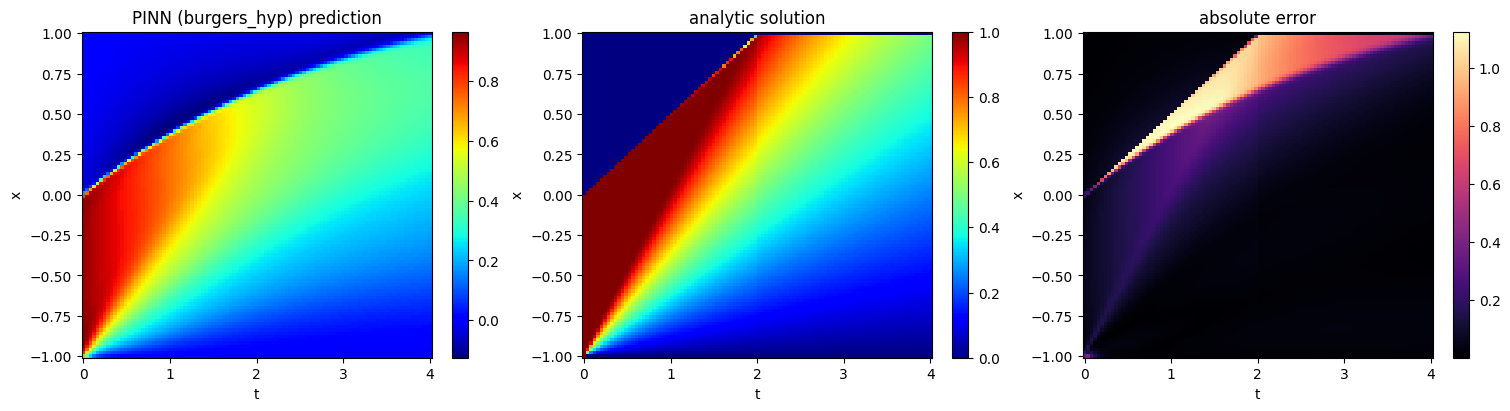

[FNO] step    1 | mse=1.789e-01
[FNO] step  500 | mse=3.407e-05
[FNO] step 1000 | mse=1.512e-04
[FNO] step 1500 | mse=5.763e-06
[FNO] step 2000 | mse=4.414e-06


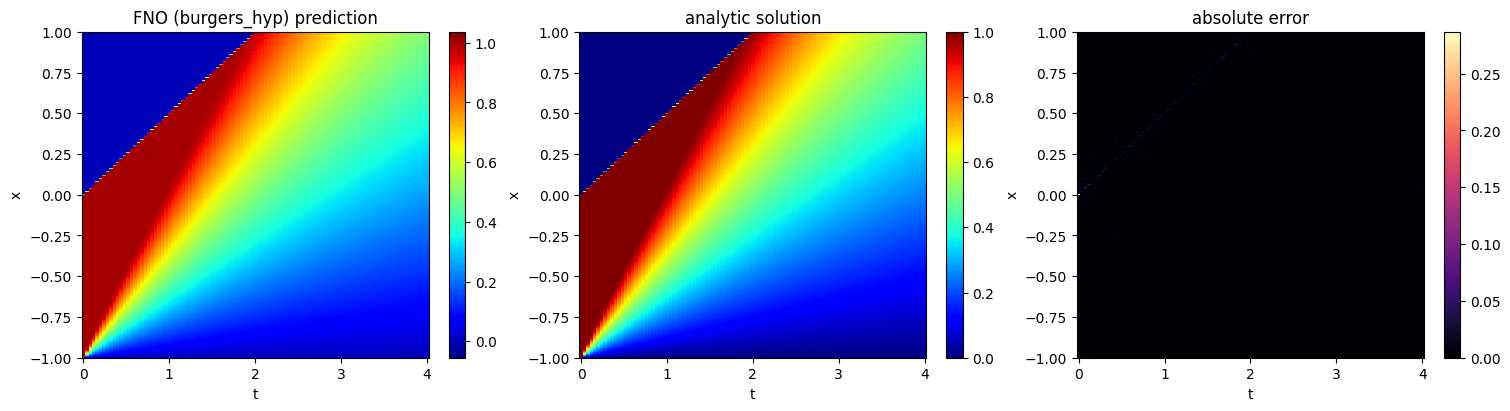

In [ ]:

pinn_defaults = dict(
    steps=1500,
    lr=1e-3,
    interior_samples=512,
    boundary_samples=512,
    initial_samples=512,
)

def train_pinn_on_data(cfg):
    model = BurgersPINN(5, 64, hard_boundary=False, hard_init=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])

    for step in range(1, cfg['steps'] + 1):
        optimizer.zero_grad(set_to_none=True)

        x_i, t_i = sample_interior(cfg['interior_samples'])
        residual = burgers_residual(model, x_i, t_i)
        loss_residual = residual.pow(2).mean()

        (x_b0, t_b0), (x_b1, t_b1) = sample_boundary(cfg['boundary_samples'])
        u_b0 = model(x_b0, t_b0)
        u_b1 = model(x_b1, t_b1)
        target_b0 = exact_solution(x_b0, t_b0)
        target_b1 = exact_solution(x_b1, t_b1)
        loss_boundary = (u_b0 - target_b0).pow(2).mean() + (u_b1 - target_b1).pow(2).mean()

        x_init, t_init = sample_initial(cfg['initial_samples'])
        u_init = model(x_init, t_init)
        target_init = exact_solution(x_init, t_init)
        loss_initial = (u_init - target_init).pow(2).mean()

        loss = loss_residual + loss_initial + loss_boundary
        loss.backward()
        optimizer.step()

        if step % 500 == 0 or step == 1:
            print(
                f"[PINN] step {step:4d} | total={loss.item():.3e} | "
                f"res={loss_residual.item():.3e} | init={loss_initial.item():.3e} | "
                f"bc={loss_boundary.item():.3e}"
            )

    return model

pinn_model = train_pinn_on_data(pinn_defaults)
X, T, U, U_exact, err = evaluate_model(pinn_model)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
plot_heatmaps(X, T, U, U_exact, err, 'PINN (burgers_hyp)', axes)
plt.show()

# FNO training on burgers_hyp.mat with default params

def train_fno_burgers_path(
    path='burgers_hyp.mat',
    modes_x=16,
    modes_t=16,
    width=32,
    layers=4,
    lr=5e-3,
    steps=2000,
    seed=42,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    inp, out, _, _ = fno_prepare_burgers_grid(path)
    inp = inp.to(device)
    out = out.to(device)

    model = FNO2d(
        in_channels=2,
        out_channels=1,
        width=width,
        modes_x=modes_x,
        modes_t=modes_t,
        layers=layers,
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for step in range(1, steps + 1):
        opt.zero_grad(set_to_none=True)
        pred = model(inp)
        loss = (pred - out).pow(2).mean()
        loss.backward()
        opt.step()
        if step % 500 == 0 or step == 1:
            print(f"[FNO] step {step:4d} | mse={loss.item():.3e}")

    return model

fno_model = train_fno_burgers_path()
plot_fno_vs_truth(fno_model, path='burgers_hyp.mat', title_prefix='FNO (burgers_hyp)')

